In [45]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.stats import linregress
from scipy.optimize import curve_fit
import sympy

import PythonGraphMod

# import math

y1 = k1 x + b1:
	k1 = 1.80
	b1 = -45.60
y2 = k2 x + b2:
	k2 = -0.23
	b2 = 1075.88
P0 = 552.98 мм. рт. ст.
I = 947.70 pA


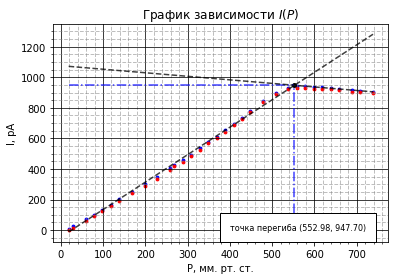

In [46]:
fd = pd.read_excel('../data/experement1.ods')

# испортируем данный из таблицы
P = np.array(fd['P, мм. рт. ст.'])
I = np.array(fd['I, pA'])
I1 = np.array(fd['I1, pA'])

fig, ax = PythonGraphMod.CreateSimpleGraph()

# создаем линейное приближение на 2х участках
lin1 = linregress(P[:22], I[:22])
lin2 = linregress(P[-8:-1], I[-8:-1])

#---------------------------------------------------------------------------------
# выводим информацию о коэффициентах линейных функций
# ищем точку их пересечения
print('y1 = k1 x + b1:\n\tk1 = %0.2f\n\tb1 = %0.2f' %(lin1.slope, lin1.intercept))
print('y2 = k2 x + b2:\n\tk2 = %0.2f\n\tb2 = %0.2f' %(lin2.slope, lin2.intercept))

P0 = (lin2.intercept - lin1.intercept) / (lin1.slope - lin2.slope) # Давление в точке перегиба
I0 = lin1.slope * P0 + lin1.intercept

assert(round(lin1.slope * P0 + lin1.intercept, 3) == round(lin2.slope * P0 + lin2.intercept, 3))

print('P0 = %0.2f мм. рт. ст.\nI = %0.2f pA' %(P0, I0))
#---------------------------------------------------------------------------------

# графики
ax.scatter(P, I, color='blue', marker='o', s=8, alpha=1)
ax.scatter(P, I1, color='red', marker='o', s=8, alpha=1)

ax.plot(P, lin1.intercept + lin1.slope * P, color='black', alpha=0.75, lw=1.5, ls='--')
ax.plot(P, lin2.intercept + lin2.slope * P, color='black', alpha=0.75, lw=1.5, ls='--')

# рисуем горизонтальную и вертикальную линии, отмечаем точку пересечения
ax.vlines(P0, I.min(), I.max(), ls='-.', color='blue', alpha=0.75)
ax.hlines(I0, P.min(), P0,      ls='-.', color='blue', alpha=0.75)
ax.scatter(P0, I0, color='black', marker='o', s=15, alpha=1)

# сетка
ax.minorticks_on()
ax.grid(which = 'major', color = 'black', linewidth = 1, linestyle = '-', alpha = 0.75)
ax.grid(which = 'minor', color = 'grey', linewidth = 1, linestyle = '--', alpha = 0.5)

# оформление
plt.title(r'График зависимости $I(P)$')
plt.ylabel('I, pA')
plt.xlabel('P, мм. рт. ст.')
ax.text(400, 0, r'точка перегиба (%0.2f, %0.2f)' %(P0, I0), 
    size = 8,
    bbox=dict(facecolor='white', edgecolor='black', pad=10.0))

fig.savefig("../images/PI.pdf")

In [47]:
# задаем функцию с неопределенными коэффициентами для приближения распределения пробегов альфа-частиц
def f(P, B1, B2, p0, dp):
    return (B1 - B2) / (1 + np.exp((P - p0) / dp)) + B2

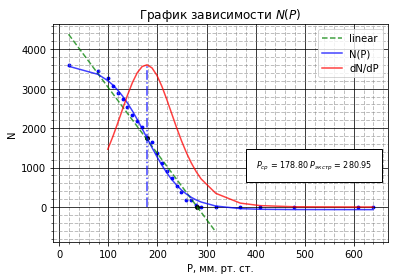

In [56]:
fd1 = pd.read_excel('../data/experement2.ods')

# импортируем данный из таблицы
P = np.array(fd1['P, мм. рт. ст.'])
N = np.array(fd1['N'])

fig1, ax1 = PythonGraphMod.CreateSimpleGraph()

# создаем линейное приближение на наклонном участке
lin = linregress(P[:21], N[:21])

# наносим на график эксперементальные точки
ax1.scatter(P, N, color='blue', marker='o', s=8, alpha=1)
ax1.plot(P[:23], lin.intercept + lin.slope * P[:23], color='green', alpha=0.75, lw=1.5, ls='--', label='linear')

#========================================================
# расчитаем экстремальное значение P
P_extr = -lin.intercept / lin.slope
ax1.scatter(P_extr, 0, color='black', marker='o', s=15, alpha=1)
#========================================================


#--------------------------------------------------------
# подберем функцию, описывающую распределение пробегов альфа-частицы
# используем функцию curve_fit пакета scipy.optimize
popt, pcov = curve_fit(f, P, N, (35500, -1200, 177, 47))

# задаем функцию в явном виде для последующего дифференцирования
x = sympy.Symbol('x')
func = (popt[0] - popt[1]) / (1 + sympy.exp((x - popt[2]) / popt[3])) + popt[1]

# диффиринцируем функцию распределения пробегов, чтобы построить график производной
diff_func = sympy.lambdify(x, sympy.diff(func))
# набор значений производной функции распределения пробегов, нормированный по размерам основного графика
diff_func_values = -150 * diff_func(P)

max_value_idx = list(diff_func_values).index(max(diff_func_values))
assert (diff_func_values[max_value_idx] == max(diff_func_values))

# наносим на график вертикальную линию и точку среднего значения ...
ax1.vlines(P[max_value_idx], N.min(), max(diff_func_values), ls='-.', color='blue', alpha=0.75)
ax1.scatter(P[max_value_idx], N[max_value_idx], color='black', marker='o', s=15, alpha=1)

# наносим на график функцию распределения пробегов и функцию ее производной
ax1.plot(P, f(P, *popt), color='blue', alpha=0.75, lw=1.5, ls='-', label='N(P)')
ax1.plot(P[2:], -150 * diff_func(P[2:]), color='red', alpha=0.75, lw=1.5, ls='-', label='dN/dP')
#--------------------------------------------------------

# сетка
ax1.minorticks_on()
ax1.grid(which = 'major', color = 'black', linewidth = 1, linestyle = '-', alpha = 0.75)
ax1.grid(which = 'minor', color = 'grey', linewidth = 1, linestyle = '--', alpha = 0.5)

# оформление
plt.title(r'График зависимости $N(P)$')
plt.ylabel('N')
plt.xlabel('P, мм. рт. ст.')
plt.legend()
ax1.text(400, 1000, r'$P_{ср}$ = %0.2f $P_{экстр}$ = %0.2f' %(P[max_value_idx], P_extr), 
    size = 8,
    bbox=dict(facecolor='white', edgecolor='black', pad=10.0))

fig1.savefig("../images/PN.pdf")